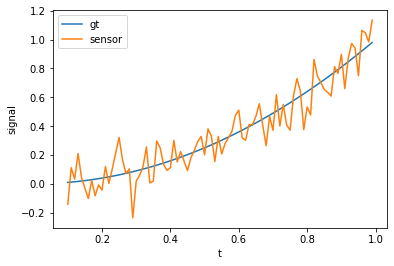

In [97]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

# 生成一段时间
t = np.arange(0.1,1,0.01)
L = len(t)

# 生成真实信号x，以及观测值y
# 首先初始化
x  = np.zeros((L))
y  = x.copy()
y2 = x.copy()

# 生成信号，设为x = t^2
for i in range(L):
    x[i]  = t[i]**2
    y[i]  = x[i] + np.random.normal(0,0.1)
    y2[i] = x[i] + np.random.normal(0,0.1)

# 开始写滤波算法了
plt.plot(t, x, label = "gt")
plt.plot(t, y, label = "sensor")
plt.xlabel("t")
plt.ylabel("signal")
plt.legend()
plt.show()

卡尔曼滤波的两大前提：
1. 预测方程需要是线性的 体现在F矩阵里都是线性的东西
2. 误差都是用高斯分布去建模的

# 不使用导数去拟合（运动学含义上是静止）

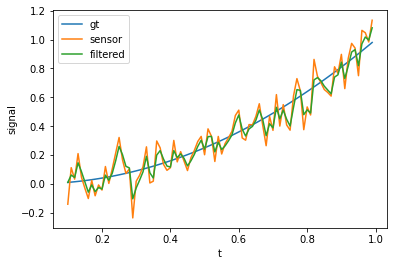

In [98]:

# 滤波算法
# 预测方程 观测方程 怎么写呢
# 观测方程好些 Y(K)=X(K)+R  R~N(0,0.1) 这里R的方差为1这里是随便给的，但是你要想真知道也是可以的，将橙色曲线的点都考虑进去，就可以算出这些点的方差
# 预测方程不好写，在这里你可能会以为是线性增长，但是大多数问题，信号是杂乱无章的，怎么办？
# 预测模型先建立个比较粗糙的

# 模型1：最粗糙的模型
# 预测模型：X(K) = X(K-1) + Q # 这是一个线性模型 # 物理含义：静止
# 观测模型：Y(K) = X(K)   + R
# 猜 Q~N(0,1)
F, H, Q, R = np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]) # Q越小，越相信预测方程，R越小，越相信观测方程 # 可改
# 初始化x(k)+
M_plus = np.zeros((L,1)) # Xplus1指的是model1的

# 设置一个初值 假设 Xplus1[0]~N(0.01, 0.01^2) 初值方差比较小，证明我们对初值比较自信
M_plus[0] = 0.01 # 可改 # 对初值不敏感
S_plus    = np.array([[0.01**2]]) # 因为每次都会更新

# 卡尔曼滤波算法
# 即从前一时刻的 + 的期望和方差
# 推出这一时刻的 - 的期望和方差，
# 再由这一时刻的 - 的期望和方差
# 推出这一时刻的 + 的期望和方差
# refer to kalman_filter_5eq.jpg

for i in range(1,L): # 0 是 初值
    # 预测步
    M_minus   = F @ M_plus[i-1]
    S_minus   = F @ S_plus @ F.T + Q
    # 更新步
    K1        = (S_minus @ H.T) * inv(H @ S_minus @ H.T + R)
    M_plus[i] = M_minus + K1 @ (y[i] - H @ M_minus)
    S_plus    = (1 - K1 @ H) @ S_minus


plt.plot(t, x, label = "gt")
plt.plot(t, y, label = "sensor")
plt.plot(t, M_plus, label = "filtered")

plt.xlabel("t")
plt.ylabel("signal")
plt.legend()
plt.show()


# 使用二阶导数去拟合（运动学的意义是匀加速直线运动）

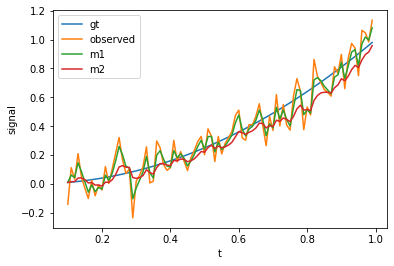

In [99]:
# 预测模型：X(K) = X(K - 1) + X'(K-1)*dt + X"(K-1)*dt^2 * (1/2!) + Q2 # 匀加速直线运动
# 观测模型：Y(K) = X(K) + R  R~N(0,1)
#      此时状态变量 X = [X(K)  X'(K)  X"(K)].T 列向量 X = [位移 速度 加速度]
# Y(K) = H * X + R             
#                  H = [1 0 0] 行向量
# refer to state_transition_matrix.jpg
dt = t[1] - t[0]
F2 = np.array([[1, dt, 0.5*dt**2],
               [0, 1,         dt],
               [0, 0,         1]]) # 注意dt是否小于计算机所能表示的精度

H2 = np.array([[1, 0, 0]])
Q2 = np.array([[1, 0,    0],
               [0, 0.01, 0],
               [0, 0,    0.0001]])

R2 = 20 # 因为只有一个观测（只有一个传感器） 

# 设置初值
# 期望
M_plus_2 = np.zeros((3, L))
M_plus_2[0,0] = 0.1 ** 2 # 初始位移
M_plus_2[1,0] = 0        # 初始速度
M_plus_2[2,0] = 0        # 初始加速度

# 方差
S_plus_2 = np.array([[0.01, 0,     0],
                     [0,    0.01,  0],
                     [0,    0,     0.0001]])


for i in range(1, L): # i 就是当前的时刻（即jpg中的k）
    # 预测步
    M_minus_2      = F2 @ M_plus_2[:, i - 1]
    S_minus_2      = F2 @ S_plus_2 @ F2.T + Q2
    K2             = S_minus_2 @ H2.T @ inv(H2 @ S_minus_2 @ H2.T + R2)
    M_plus_2[:,i]  = M_minus_2 + K2@(y[i] - H2 @ M_minus_2)
    S_plus_2       = (np.identity(3) - K2@H2)@S_minus_2


plt.plot(t, x, label = "gt")
plt.plot(t, y, label = "observed")
plt.plot(t, M_plus, label = "m1")
plt.plot(t, M_plus_2[0,:], label = "m2"), 

plt.xlabel("t")
plt.ylabel("signal")
plt.legend()
plt.show()

# 使用三阶导数拟合

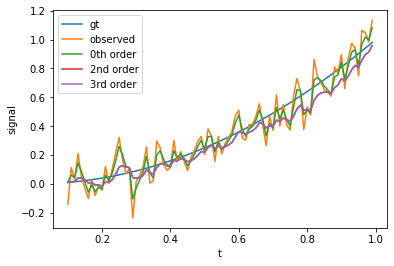

In [100]:
# 预测模型：X(K) = X(K - 1) + X'(K-1)*dt + X"(K-1)*dt^2 * (1/2!) + x'''(K-1)*dt**3 * (1/3!) + Q3
# 观测模型：Y(K) = X(K) + R  R~N(0,1)
#      此时状态变量 X = [X(K)  X'(K)  X"(K)  X'''(K)].T 
# Y(K) = H * X + R             
#                  H = [1 0 0 0] 行向量
dt = t[1] - t[0]
F3 = np.array([[1, dt, 1/2*dt**2, 1/6*dt**3],
               [0, 1,  dt,        1/2*dt**2],
               [0, 0,  1,          dt      ],
               [0, 0,  0,          1       ]]) # 注意dt是否小于计算机所能表示的精度

H3 = np.array([[1, 0, 0, 0]])
Q3 = np.array([[1, 0,    0,      0],
               [0, 0.01, 0,      0],
               [0, 0,    0.0001, 0],
               [0, 0,    0,      0.0001]])


R3 = 20 # 因为只有一个观测（只有一个传感器） 

# 设置初值
# 期望
M_plus_3 = np.zeros((4, L))
M_plus_3[0,0] = 0.1 ** 2 
M_plus_3[1,0] = 0        
M_plus_3[2,0] = 0        
M_plus_3[3,0] = 0        


# 方差
S_plus_3 = np.array([[0.01, 0,     0,      0],
                     [0,    0.01,  0,      0],
                     [0,    0,     0.0001, 0],
                     [0, 0,    0,      0.00001]])


for i in range(1, L): # i 就是当前的时刻（即jpg中的k）
    # 预测步
    M_minus_3      = F3 @ M_plus_3[:, i - 1]
    S_minus_3      = F3 @ S_plus_3 @ F3.T + Q3
    K3             = S_minus_3 @ H3.T @ inv(H3 @ S_minus_3 @ H3.T + R3)
    M_plus_3[:,i]  = M_minus_3 + K3@(y[i] - H3 @ M_minus_3)
    S_plus_3       = (np.identity(4) - K3@H3)@S_minus_3


plt.plot(t, x, label = "gt")
plt.plot(t, y, label = "observed")
plt.plot(t, M_plus, label = "0th order")
plt.plot(t, M_plus_2[0,:], label = "2nd order")
plt.plot(t, M_plus_3[0,:], label = "3rd order"), 

plt.xlabel("t")
plt.ylabel("signal")
plt.legend()
plt.show()

# 两个传感器

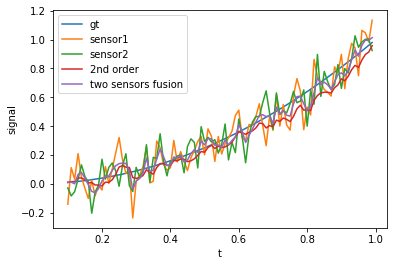

In [104]:
# 预测模型：X(K) = X(K - 1) + X'(K-1)*dt + X"(K-1)*dt^2 * (1/2!) + Q2 # 匀加速直线运动
# 观测模型：Y(K) = X(K) + R  R~N(0,1)
#      此时状态变量 X = [X(K)  X'(K)  X"(K)].T 列向量 X = [位移 速度 加速度]
# Y(K) = H * X + R             
#                  H = [1 0 0] 行向量
# refer to state_transition_matrix.jpg
dt = t[1] - t[0]
F4 = np.array([[1, dt, 0.5*dt**2],
               [0, 1,         dt],
               [0, 0,         1]]) # 注意dt是否小于计算机所能表示的精度

H4 = np.array([[1, 0, 0],
               [1, 0, 0]])
               
Q4 = np.array([[1, 0,    0],
               [0, 0.01, 0],
               [0, 0,    0.0001]])

R4 = np.array([[3, 0],
               [0, 3]]) # 有两个传感器，这两个传感器的误差都是假设服从高斯分布的，不相关，且独立 

# 设置初值
# 期望
M_plus_4 = np.zeros((3, L))
M_plus_4[0,0] = 0.1 ** 2 # 初始位移
M_plus_4[1,0] = 0        # 初始速度
M_plus_4[2,0] = 0        # 初始加速度

# 方差
S_plus_4 = np.array([[0.01, 0,     0],
                     [0,    0.01,  0],
                     [0,    0,     0.0001]])


for i in range(1, L): # i 就是当前的时刻（即jpg中的k）
    # 预测步
    M_minus_4      = F4 @ M_plus_4[:, i - 1:i]
    S_minus_4      = F4 @ S_plus_4 @ F4.T + Q4
    K4             = S_minus_4 @ H4.T @ inv(H4 @ S_minus_4 @ H4.T + R4)
    # 更新步
    Y = np.zeros((2,1))
    Y[0,0] = y[i]
    Y[1,0] = y2[i]
    M_plus_4[:,i:i+1]  = M_minus_4 + K4@(Y - H4 @ M_minus_4)
    S_plus_4       = (np.identity(3) - K4@H4)@S_minus_4


plt.plot(t, x, label = "gt")
plt.plot(t, y, label = "sensor1")
plt.plot(t, y2, label = "sensor2")
# plt.plot(t, M_plus, label = "0th order")
plt.plot(t, M_plus_2[0,:], label = "2nd order")
plt.plot(t, M_plus_4[0,:], label = "two sensors fusion"), 

plt.xlabel("t")
plt.ylabel("signal")
# plt.title("gt and sensor data")
plt.legend()
plt.show()